In [171]:
# Importing standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, f_oneway, pearsonr
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from statsmodels.multivariate.manova import MANOVA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans




In [172]:
# Load the dataset
df = pd.read_csv("../Data/segments0324.csv")

# 1.1 Check the Dataset Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           8000 non-null   int64  
 1   Age                  8000 non-null   int64  
 2   Gender               8000 non-null   object 
 3   Income               8000 non-null   int64  
 4   CampaignChannel      8000 non-null   object 
 5   CampaignType         8000 non-null   object 
 6   AdSpend              8000 non-null   float64
 7   ClickThroughRate     8000 non-null   float64
 8   ConversionRate       8000 non-null   float64
 9   WebsiteVisits        8000 non-null   int64  
 10  PagesPerVisit        8000 non-null   float64
 11  TimeOnSite           8000 non-null   float64
 12  SocialShares         8000 non-null   int64  
 13  EmailOpens           8000 non-null   int64  
 14  EmailClicks          8000 non-null   int64  
 15  PreviousPurchases    8000 non-null   i

In [173]:
# 1.4 Standardize boolean campaign columns (if present) by converting True/False to 1/0
binary_cols = df.select_dtypes(include='bool').columns
df[binary_cols] = df[binary_cols].astype(int)

# 1.5 Convert object columns to category
categorical_cols = ['Gender', 'CampaignChannel', 'CampaignType', 'AdvertisingPlatform', 'AdvertisingTool']
for col in categorical_cols:
    df[col] = df[col].astype('category')

df.head()

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,...,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion,Cluster_Label
0,8000,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,...,7.396803,19,6,9,4,688,IsConfid,ToolConfid,1,3
1,8001,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,...,5.352549,5,2,7,2,3459,IsConfid,ToolConfid,1,2
2,8002,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,...,13.794901,0,11,2,8,2337,IsConfid,ToolConfid,1,3
3,8003,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,...,14.688363,89,2,2,0,2463,IsConfid,ToolConfid,1,4
4,8004,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,...,13.993370,6,6,6,8,4345,IsConfid,ToolConfid,1,4


### Analysis the clustering

In [209]:
behavioral_metrics = [
    'WebsiteVisits', 'PagesPerVisit', 'TimeOnSite',
    'SocialShares', 'EmailOpens', 'EmailClicks',
    'AdSpend', 'ClickThroughRate', 'ConversionRate', 
    'PreviousPurchases', 'LoyaltyPoints', 'Income','Conversion', 'Age'
]

In [210]:
# Step 1: MANOVA
df['Cluster_Label'] = df['Cluster_Label'].astype('category')
formula = ' + '.join(behavioral_metrics) + ' ~ Cluster_Label'
manova = MANOVA.from_formula(formula, data=df)
manova_result = manova.mv_test()
print("### MANOVA Results ###")
print(manova_result)
p_value = manova_result.results['Cluster_Label']['stat'].loc["Wilks' lambda", 'Pr > F']

### MANOVA Results ###
                    Multivariate linear model
                                                                  
------------------------------------------------------------------
        Intercept        Value   Num DF   Den DF   F Value  Pr > F
------------------------------------------------------------------
           Wilks' lambda 0.0949 14.0000 7981.0000 5435.5831 0.0000
          Pillai's trace 0.9051 14.0000 7981.0000 5435.5831 0.0000
  Hotelling-Lawley trace 9.5349 14.0000 7981.0000 5435.5831 0.0000
     Roy's greatest root 9.5349 14.0000 7981.0000 5435.5831 0.0000
------------------------------------------------------------------
                                                                  
------------------------------------------------------------------
     Cluster_Label      Value   Num DF   Den DF    F Value  Pr > F
------------------------------------------------------------------
          Wilks' lambda 0.1771 70.0000 38001.2478  238.0353 

In [211]:
print("\n=== Interpretation Summary ===")
if p_value < 0.05:
    print(f"MANOVA: Significant (p = {p_value:.4f}) → behavioral differences exist between clusters.")
else:
    print(f"MANOVA: Not significant (p = {p_value:.4f}) → no strong behavioral difference across clusters.")


=== Interpretation Summary ===
MANOVA: Significant (p = 0.0000) → behavioral differences exist between clusters.


In [212]:
# Step 2: LDA
X = df[behavioral_metrics]
y = df['Cluster_Label'].cat.codes
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)
lda_coeff_df = pd.DataFrame(lda.coef_, columns=behavioral_metrics)
print("\n### LDA Coefficients ###")
print(lda_coeff_df)
print("\nLDA Explained Variance Ratio:")
print(lda.explained_variance_ratio_)


### LDA Coefficients ###
   WebsiteVisits  PagesPerVisit  TimeOnSite  SocialShares  EmailOpens  \
0      -0.002979      -0.002423    0.019476      0.000858   -0.001397   
1      -0.007520      -0.028822   -0.109415      0.001199   -0.013644   
2       0.002027       0.009796    0.001340     -0.000119    0.000886   
3       0.001766       0.004472    0.016229      0.000334    0.000754   
4      -0.001345       0.000202    0.016327     -0.001633    0.013050   
5      -0.005406      -0.052925   -0.091827      0.000013   -0.037383   

   EmailClicks   AdSpend  ClickThroughRate  ConversionRate  PreviousPurchases  \
0     0.039353  0.000010          0.700830        1.201056           0.025024   
1    -0.090271 -0.000119         -3.676847       -4.243468          -0.108251   
2     0.009009  0.000008          0.372374        0.516707           0.004741   
3     0.002973  0.000019          0.413115        0.431888           0.005898   
4     0.021663  0.000005          0.541891        0.32714

In [213]:
lda_importance = lda_coeff_df.abs().max().sort_values(ascending=False)
top_vars = lda_importance.index.tolist()
print(lda_importance)

Conversion           43.913329
ConversionRate        4.509193
ClickThroughRate      4.004159
EmailClicks           0.112904
TimeOnSite            0.109415
PreviousPurchases     0.108251
PagesPerVisit         0.052925
EmailOpens            0.037383
Age                   0.009117
WebsiteVisits         0.007520
SocialShares          0.001633
AdSpend               0.000119
LoyaltyPoints         0.000116
Income                0.000004
dtype: float64


In [179]:
# Step 3: Dunn Index
# Compute pairwise distance between all points
def compute_dunn_index(X, labels):
    distances = pairwise_distances(X)
    unique_labels = np.unique(labels)
    inter_cluster = np.inf
    intra_cluster = 0
    for i in unique_labels:
        cluster_i = np.where(labels == i)[0]
        if len(cluster_i) > 1:
            d_intra = np.max(distances[np.ix_(cluster_i, cluster_i)])
            intra_cluster = max(intra_cluster, d_intra)
        for j in unique_labels:
            if i < j:
                cluster_j = np.where(labels == j)[0]
                d_inter = np.min(distances[np.ix_(cluster_i, cluster_j)])
                inter_cluster = min(inter_cluster, d_inter)
    return inter_cluster / intra_cluster if intra_cluster > 0 else np.nan

dunn = compute_dunn_index(X.values, y.values)
print("\n### Dunn Index ###")
print(f"Dunn Index: {dunn:.4f}")


### Dunn Index ###
Dunn Index: 0.0004


In [180]:
if dunn > 0.5:
    print(f"Dunn Index: {dunn:.4f} → clusters are well-separated.")
else:
    print(f"Dunn Index: {dunn:.4f} → clusters are not well-separated.")

Dunn Index: 0.0004 → clusters are not well-separated.


### KMeans centroids or means

In [181]:
# Prepare data for KMeans
X_kmeans = df[behavioral_metrics]

# Fit KMeans model using the number of existing segments
n_clusters = df['Cluster_Label'].nunique()
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(X_kmeans)

# Get KMeans centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=behavioral_metrics)
centroids['KMeans_Cluster'] = range(n_clusters)

# Display the result
print("### KMeans Cluster Centroids ###")
print(centroids.round(2))


### KMeans Cluster Centroids ###
   WebsiteVisits  PagesPerVisit  TimeOnSite  SocialShares  EmailOpens  \
0          24.65           5.63        7.59         50.26        9.55   
1          24.61           5.55        7.72         49.34        9.23   
2          25.09           5.48        7.73         50.25        9.49   
3          24.47           5.68        7.92         49.58        9.68   
4          24.94           5.46        7.72         49.85        9.42   
5          24.75           5.51        7.69         49.49        9.49   

   EmailClicks  AdSpend  ClickThroughRate  ConversionRate  PreviousPurchases  \
0         4.39  5002.24              0.16            0.10               4.58   
1         4.50  5059.64              0.16            0.11               4.44   
2         4.46  5055.54              0.15            0.11               4.50   
3         4.45  4991.21              0.15            0.10               4.45   
4         4.53  4979.93              0.16            0.

In [182]:
# Segment-wise Behavioral Summary
behavior_summary = df.groupby('Cluster_Label', observed=False)[behavioral_metrics].mean().reset_index()

behavior_summary 



,Cluster_Label,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,AdSpend,ClickThroughRate,ConversionRate,PreviousPurchases,LoyaltyPoints,Income,Conversion
0,0,24.383690,5.600666,8.052900,50.477273,9.596257,4.823529,5103.889242,0.160125,0.108279,4.711230,2581.030749,83118.402406,1.000000
1,1,21.405354,4.873681,5.884563,51.200765,7.801147,3.447419,3828.730274,0.125252,0.089418,3.414914,2103.126195,83516.326960,0.011472
2,2,25.375420,5.667805,7.742781,49.688910,9.641383,4.572252,5093.838890,0.157882,0.106172,4.548248,2531.552088,82868.022564,0.968315
3,3,25.304376,5.635073,8.008285,50.022534,9.639778,4.525147,5178.631914,0.158158,0.105990,4.551274,2520.348138,86642.144350,0.973547
4,4,24.736045,5.614727,7.997754,48.354067,10.070973,4.681021,5071.923809,0.159188,0.105696,4.740032,2557.686603,85169.217703,0.999203
5,5,21.881818,4.711097,6.187224,50.169697,7.054545,3.266667,4120.587190,0.122972,0.088219,3.696970,2102.224242,81052.830303,0.021212


In [183]:
print("Variance across KMeans centroids:")
print(centroids.var())

print("\nVariance across Group Means:")
print(behavior_summary[behavioral_metrics].var())


Variance across KMeans centroids:
WebsiteVisits        5.134427e-02
PagesPerVisit        7.579305e-03
TimeOnSite           1.145778e-02
SocialShares         1.548788e-01
EmailOpens           2.189808e-02
EmailClicks          2.288306e-03
AdSpend              2.973318e+03
ClickThroughRate     8.560462e-06
ConversionRate       2.804698e-06
PreviousPurchases    3.194926e-03
LoyaltyPoints        1.284646e+03
Income               1.637735e+09
Conversion           2.716682e-05
KMeans_Cluster       3.500000e+00
dtype: float64

Variance across Group Means:
WebsiteVisits        3.072404e+00
PagesPerVisit        1.900511e-01
TimeOnSite           9.984550e-01
SocialShares         9.007096e-01
EmailOpens           1.507767e+00
EmailClicks          4.599415e-01
AdSpend              3.547948e+05
ClickThroughRate     3.227218e-04
ConversionRate       8.467196e-05
PreviousPurchases    3.262766e-01
LoyaltyPoints        5.324571e+04
Income               3.776371e+06
Conversion           2.505269e-01
dty

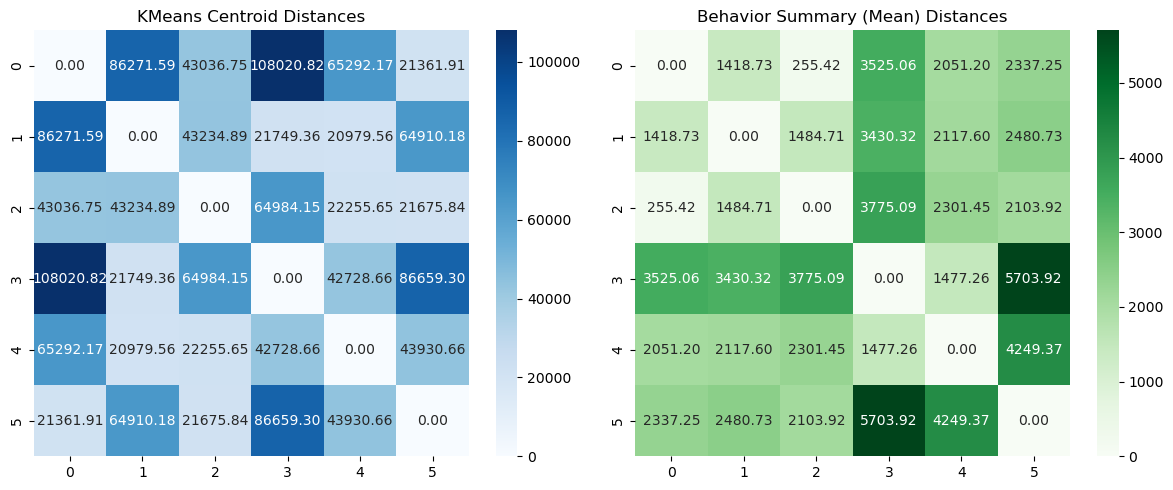


Average Pairwise Distance (KMeans Centroids): 42060.63849675863
Average Pairwise Distance (Group Means): 2150.6685613961818


In [184]:
from sklearn.metrics import pairwise_distances

kmeans_dist = pairwise_distances(centroids[behavioral_metrics])
summary_dist = pairwise_distances(behavior_summary[behavioral_metrics])

# Plot heatmaps
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(kmeans_dist, annot=True, fmt=".2f", cmap="Blues")
plt.title("KMeans Centroid Distances")

plt.subplot(1, 2, 2)
sns.heatmap(summary_dist, annot=True, fmt=".2f", cmap="Greens")
plt.title("Behavior Summary (Mean) Distances")

plt.tight_layout()
plt.show()

# Print average pairwise distances
import numpy as np
print("\nAverage Pairwise Distance (KMeans Centroids):", np.mean(kmeans_dist))
print("Average Pairwise Distance (Group Means):", np.mean(summary_dist))

### Scoring System

In [185]:
product_features = ['PreviousPurchases', 'LoyaltyPoints', 'Income']
transaction_features = ['AdSpend', 'ClickThroughRate', 'ConversionRate', 'Conversion']
engagement_features = ['WebsiteVisits', 'PagesPerVisit', 'TimeOnSite', 'EmailOpens', 'EmailClicks', 'SocialShares']

In [188]:
# Extract LDA importance and normalize to get weights
lda_weights = lda_importance / lda_importance.sum()

# Normalize features in behavior summary
scaler = MinMaxScaler()
normalized_df = pd.DataFrame(
    scaler.fit_transform(behavior_summary[lda_weights.index]),
    columns=lda_weights.index
)

# Compute overall LDA-weighted score
behavior_summary['LDA_Score'] = (normalized_df * lda_weights).sum(axis=1)



In [189]:
behavior_summary['Total_Score'] = behavior_summary['LDA_Score']
# Rank the segments
behavior_summary['Rank'] = behavior_summary['Total_Score'].rank(method='dense', ascending=False).astype(int)
behavior_summary = behavior_summary.sort_values('Rank')

print("\n### Cluster Total Score and Rank ###")
print(behavior_summary[['Cluster_Label', 'Total_Score', 'Rank']].sort_values('Rank').round(3))


### Cluster Total Score and Rank ###
  Cluster_Label  Total_Score  Rank
0             0        1.000     1
4             4        0.986     2
3             3        0.963     3
2             2        0.959     4
1             1        0.010     5
5             5        0.009     6


In [190]:
# Normalize again for each subscore (reuse normalized_df)
behavior_summary['ProductUsage_Score'] = (normalized_df[product_features] * lda_weights[product_features]).sum(axis=1)
behavior_summary['Transaction_Score'] = (normalized_df[transaction_features] * lda_weights[transaction_features]).sum(axis=1)
behavior_summary['Engagement_Score'] = (normalized_df[engagement_features] * lda_weights[engagement_features]).sum(axis=1)

In [191]:
# Normalize the sub-scores before computing total
behavior_summary[['ProductUsage_Score', 'Transaction_Score', 'Engagement_Score']] = scaler.fit_transform(
    behavior_summary[['ProductUsage_Score', 'Transaction_Score', 'Engagement_Score']]
)

# Total score using subcomponents (optional)
behavior_summary['Total_Score'] = (
    0.4 * behavior_summary['ProductUsage_Score'] +
    0.3 * behavior_summary['Transaction_Score'] +
    0.3 * behavior_summary['Engagement_Score']
)

# Rank the segments
behavior_summary['Rank'] = behavior_summary['Total_Score'].rank(method='dense', ascending=False).astype(int)
behavior_summary = behavior_summary.sort_values('Rank')


print("\n### Cluster Behavioral Scores and Rank ###")
print(behavior_summary[['Cluster_Label', 'ProductUsage_Score', 'Transaction_Score', 
                 'Engagement_Score', 'Total_Score', 'Rank']].sort_values('Rank').round(3))




### Cluster Behavioral Scores and Rank ###
  Cluster_Label  ProductUsage_Score  Transaction_Score  Engagement_Score  \
0             0               0.978              1.000             1.000   
4             4               1.000              0.986             0.976   
3             3               0.858              0.963             0.931   
2             2               0.855              0.959             0.904   
5             5               0.213              0.000             0.000   
1             1               0.000              0.002             0.054   

   Total_Score  Rank  
0        0.991     1  
4        0.989     2  
3        0.911     3  
2        0.901     4  
5        0.085     5  
1        0.017     6  


### Recommendation desicion tree

In [217]:
# Thresholds for dynamic segmentation
high_conversion_rate_threshold = behavior_summary['ConversionRate'].quantile(0.75)
low_actual_conversion_threshold = behavior_summary['Conversion'].quantile(0.25)
high_actual_conversion_threshold = behavior_summary['Conversion'].quantile(0.75)
low_transaction_threshold = behavior_summary['Transaction_Score'].quantile(0.25)
high_engagement_threshold = behavior_summary['Engagement_Score'].quantile(0.75)
high_product_usage_threshold = behavior_summary['ProductUsage_Score'].quantile(0.75)

print(high_conversion_rate_threshold)


0.10612643545440423


In [220]:
campaign_recommendations = []

for _, row in behavior_summary.iterrows():
    cluster = row['Cluster_Label']
    actual_conversion = row['Conversion']
    predicted_conversion = row['ConversionRate']
    
    rec_types = set()
    rec_channels = set()

    # Logic-based tagging
    if predicted_conversion > high_conversion_rate_threshold and actual_conversion < low_actual_conversion_threshold:
        rec_types.add("Conversion")
        rec_channels.update(["PPC", "Email"])

    if actual_conversion > high_actual_conversion_threshold:
        rec_types.add("Retention")
        rec_channels.update(["Email", "Referral"])

    if row['ProductUsage_Score'] > high_product_usage_threshold and row['Transaction_Score'] < low_transaction_threshold:
        rec_types.add("Consideration")
        rec_channels.update(["SEO", "Email"])

    if row['Transaction_Score'] < low_transaction_threshold and row['Engagement_Score'] > high_engagement_threshold:
        rec_types.add("Conversion")
        rec_channels.update(["Social Media", "PPC"])

    if row['Total_Score'] > 0.75:
        rec_types.add("Retention")
        rec_channels.update(["Email", "Referral"])

    if not rec_types:
        rec_types.add("Awareness")
        rec_channels.update(["SEO", "Social Media"])

    # Save to list
    campaign_recommendations.append({
        'Cluster_Label': cluster,
        'Recommended_CampaignTypes': list(rec_types),
        'Recommended_CampaignChannels': list(rec_channels)
    })



In [221]:
recommendation_df = pd.DataFrame(campaign_recommendations)
behavior_summary = behavior_summary.merge(recommendation_df, on='Cluster_Label', how='left')

recommendation_df 

,Cluster_Label,Recommended_CampaignTypes,Recommended_CampaignChannels
0,0,[Retention],"[Email, Referral]"
1,4,[Retention],"[Email, Referral]"
2,3,[Retention],"[Email, Referral]"
3,2,[Retention],"[Email, Referral]"
4,5,[Awareness],"[Social Media, SEO]"
5,1,[Awareness],"[Social Media, SEO]"


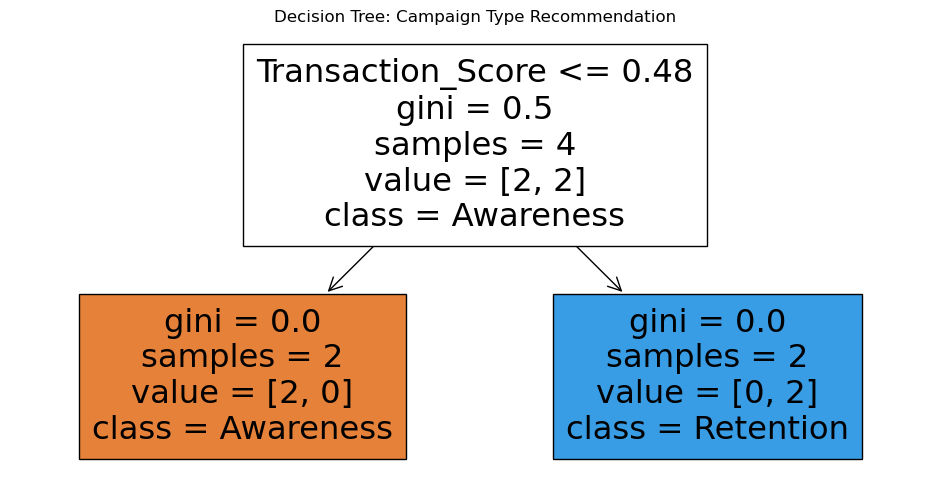

   Cluster_Label Primary_CampaignType Predicted_CampaignType
0              0            Retention              Retention
1              4            Retention              Retention
2              3            Retention              Retention
3              2            Retention              Retention
4              5            Awareness              Awareness
5              1            Awareness              Awareness


In [208]:
# Step 1: Create a Primary_CampaignType label from rule-based multi-labels
behavior_summary['Primary_CampaignType'] = behavior_summary['Recommended_CampaignTypes'].apply(
    lambda x: x[0] if isinstance(x, list) and len(x) > 0 else 'Awareness'
)

# Step 2: Prepare data for Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define features and target
tree_features = ['ProductUsage_Score', 'Transaction_Score', 'Engagement_Score']
X = behavior_summary[tree_features]
y = behavior_summary['Primary_CampaignType']

# Optional: Split for validation (not mandatory with small datasets)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Train the decision tree model
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

# Step 4: Visualize the decision tree
plt.figure(figsize=(12,6))
plot_tree(clf, feature_names=tree_features, class_names=clf.classes_, filled=True)
plt.title("Decision Tree: Campaign Type Recommendation")
plt.show()

# Step 5: Predict CampaignType for each segment (optional)
behavior_summary['Predicted_CampaignType'] = clf.predict(X)

# Display predicted vs original for review
print(behavior_summary[['Cluster_Label', 'Primary_CampaignType', 'Predicted_CampaignType']])